In [2]:
import os
import platform
from datetime import datetime

import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.python.keras.metrics import Precision, Recall, BinaryAccuracy

from modules.dataset_utils import DatasetUtils

#######################################################################################################################
# PARÁMETROS DEFINIDOS EN FUNCIÓN DEL USUARIO
#######################################################################################################################

# Ruta hacia los CSV del dataset
train_file_relative = './data/700Train.csv'
validation_file_relative = './data/700Validation.csv'
test_file_relative = './data/700Test.csv'

# Ruta al directorio de imágenes con máscara aplicada
masked_dir_relative = '../local/output_edited'

model_dir_relative = "./models"

# Ruta relativa hacia la librería ai4eutils
ai4eutils_relative = "./repos/ai4eutils"

# Ruta relativa hacia la librería CameraTraps
CameraTraps_relative = "./repos/CameraTraps"

#######################################################################################################################
# PARÁMETROS PARA CNN
#######################################################################################################################

IMG_HEIGHT = IMG_WEIGHT = 500
EPOCHS = 15
BATCH_SIZE = 16

#######################################################################################################################
#######################################################################################################################

home = os.path.expanduser("~")

ai4utils = os.path.abspath(ai4eutils_relative)
CameraTraps = os.path.abspath(CameraTraps_relative)
train_file = os.path.abspath(train_file_relative)
validation_file = os.path.abspath(validation_file_relative)
test_file = os.path.abspath(test_file_relative)
masked_dir = os.path.abspath(masked_dir_relative)
model_dir = os.path.abspath(model_dir_relative)

try:
    os.environ['PYTHONPATH']
except KeyError:
    os.environ['PYTHONPATH'] = ""
if platform.system() == 'Windows':
    os.environ['PYTHONPATH'] += (";" + ai4utils)
    os.environ['PYTHONPATH'] += (";" + CameraTraps)
else:
    os.environ['PYTHONPATH'] += (":" + ai4utils)
    os.environ['PYTHONPATH'] += (":" + CameraTraps)

print('==============================================================================================================')
print('PYTHONPATH: ' + os.environ['PYTHONPATH'])
print('')
print('ai4eutils PATH: ' + '\t\t' + ai4utils)
print('CameraTraps PATH: ' + '\t\t' + CameraTraps)
print('Train CSV PATH: ' + '\t\t' + train_file)
print('Validation CSV PATH: ' + '\t' + validation_file)
print('Test CSV PATH: ' + '\t\t\t' + test_file)
print('masked PATH: ' + '\t\t\t' + masked_dir)
print('models PATH: ' + '\t\t\t' + model_dir)
print('==============================================================================================================')

PYTHONPATH: /Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo:/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/ai4eutils:/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/CameraTraps:/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/ai4eutils:/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/CameraTraps

ai4eutils PATH: 		/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/ai4eutils
CameraTraps PATH: 		/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/CameraTraps
Train CSV PATH: 		/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/data/700Train.csv
Validation CSV PATH: 	/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/data/700Validation.csv
Test CSV PATH: 			/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/data/700Test.csv
masked PATH: 			/Users/carlos/WORKSPACE/local/output_edited
models PATH: 			/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/models


In [2]:
file_path, labels = DatasetUtils.load_dataset(train_file, masked_dir)
TRAIN_BUFFER = len(labels)
train_dataset = tf.data.Dataset.from_tensor_slices((file_path, labels))
train_dataset = train_dataset.map(DatasetUtils.load_image).map(DatasetUtils.normalize_images).map(
    DatasetUtils.resize_image).shuffle(TRAIN_BUFFER).batch(BATCH_SIZE)

file_path, labels = DatasetUtils.load_dataset(validation_file, masked_dir)
VALIDATION_BUFFER = len(labels)
validation_dataset = tf.data.Dataset.from_tensor_slices((file_path, labels))
validation_dataset = validation_dataset.map(DatasetUtils.load_image).map(DatasetUtils.normalize_images).map(
    DatasetUtils.resize_image).shuffle(VALIDATION_BUFFER).batch(BATCH_SIZE)

file_path, labels = DatasetUtils.load_dataset(test_file, masked_dir)
TEST_BUFFER = len(labels)
test_dataset = tf.data.Dataset.from_tensor_slices((file_path, labels))
test_dataset = test_dataset.map(DatasetUtils.load_image).map(DatasetUtils.normalize_images).map(
    DatasetUtils.resize_image).shuffle(TEST_BUFFER).batch(BATCH_SIZE)

Metal device set to: Apple M1


2022-10-05 15:03:04.745096: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-05 15:03:04.745183: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
model = keras.Sequential([

    layers.Conv2D(16, kernel_size=3, padding='same', activation=tf.nn.relu, input_shape=(IMG_HEIGHT, IMG_WEIGHT, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, kernel_size=3, padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, kernel_size=3, padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, kernel_size=3, padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(16, kernel_size=3, padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(2, 2),

    # Full connected
    layers.Flatten(),
    layers.Dense(1024, kernel_regularizer=keras.regularizers.l2(1e-3), activation=tf.nn.relu),
    layers.Dropout(0.5),
    layers.Dense(1024, kernel_regularizer=keras.regularizers.l2(1e-3), activation=tf.nn.relu),
    layers.Dropout(0.5),

    # Capa de salida
    layers.Dense(1, activation=tf.nn.sigmoid)
])

In [4]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=[keras.losses.BinaryCrossentropy()],
              metrics=['accuracy'])
#model.summary()

In [5]:
hist = model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset, batch_size=BATCH_SIZE)

Epoch 1/15


2022-10-05 15:03:05.691285: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-05 15:03:05.691664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - ETA: 0s - loss: 0.6491 - accuracy: 0.6641

2022-10-05 15:03:33.692986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - 31s 271ms/step - loss: 0.6491 - accuracy: 0.6641 - val_loss: 0.6271 - val_accuracy: 0.6603
Epoch 2/15
91/91 [==============================] - 27s 258ms/step - loss: 0.5838 - accuracy: 0.6628 - val_loss: 0.4769 - val_accuracy: 0.6603
Epoch 3/15
91/91 [==============================] - 26s 259ms/step - loss: 0.4856 - accuracy: 0.8248 - val_loss: 0.4245 - val_accuracy: 0.9103
Epoch 4/15
91/91 [==============================] - 26s 259ms/step - loss: 0.4120 - accuracy: 0.8586 - val_loss: 0.3434 - val_accuracy: 0.9006
Epoch 5/15
91/91 [==============================] - 26s 259ms/step - loss: 0.3874 - accuracy: 0.8697 - val_loss: 0.3309 - val_accuracy: 0.8846
Epoch 6/15
91/91 [==============================] - 27s 263ms/step - loss: 0.3574 - accuracy: 0.8855 - val_loss: 0.3261 - val_accuracy: 0.9071
Epoch 7/15
91/91 [==============================] - 26s 260ms/step - loss: 0.3473 - accuracy: 0.8897 - val_loss: 0.2980 - val_accuracy: 0.9103
Epoch 8/15

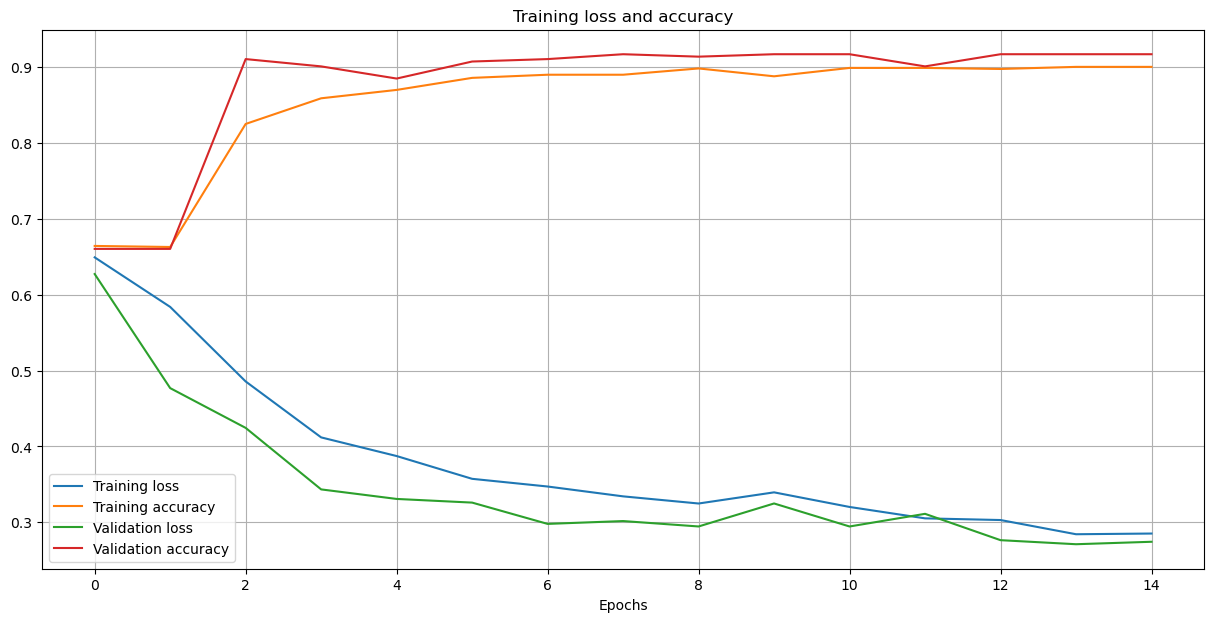

In [6]:
ax = pd.DataFrame(data=hist.history).plot(figsize=(15, 7))
ax.grid()
_ = ax.set(title="Training loss and accuracy", xlabel="Epochs")
_ = ax.legend(["Training loss", "Training accuracy", "Validation loss", "Validation accuracy"])

In [1]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='blue', label='loss', )
plt.plot(hist.history['val_loss'], color='green', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

NameError: name 'plt' is not defined

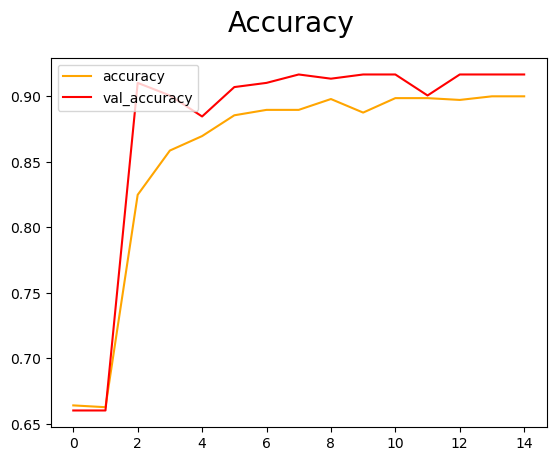

In [8]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='orange', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='red', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [9]:
results = model.evaluate(test_dataset, verbose=1)

20/20 [==============================] - 2s 86ms/step - loss: 0.3157 - accuracy: 0.8907


In [10]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for sample in test_dataset:
    X = sample[0]
    y = sample[1]
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print('Precision: ' + str(pre.result()))
print('Recall: ' + str(re.result()))
print('BinaryAccuracy: ' + str(acc.result()))

1/1 [==============================] - 0s 88ms/step


2022-10-05 15:09:48.857336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 36ms/step
Precision: tf.Tensor(0.8675214, shape=(), dtype=float32)
Recall: tf.Tensor(0.9854369, shape=(), dtype=float32)
BinaryAccuracy: tf.Tensor(0.89375, shape=(), dtype=float32)


In [11]:
date = datetime.utcnow().strftime('%Y-%m-%d_%H-%M')
if platform.system() == 'Windows':
    path = model_dir + '\\' + date
else:
    path = model_dir + '/' + date

model.save(path)

INFO:tensorflow:Assets written to: /Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/models/2022-10-05_13-09/assets


INFO:tensorflow:Assets written to: /Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/models/2022-10-05_13-09/assets
